In [1]:
import sys
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
from pathlib import Path
import psana as ps

sys.path.append('./')
import svd_waveform_processing as proc

sys.path.append('/reg/neh/home/espov/python/smalldata_tools/') # path to smalldata_tools
from smalldata_tools.SmallDataUtils import getUserData

In [2]:
plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=14)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

## TO DO:

- Improve fit by aligning the waveforms: just roll waveform by +/- 5-10 indices in steps of 1 and keep best score. Using convolution might be unnecessarily complex.

### Define the DetObjectFunc

In [3]:
import smalldata_tools.DetObject as dobj
from smalldata_tools.DetObject import DetObjectFunc

from smd_svd import *

# Test the multipulse fit DetObjectFunc

## (i) On single pulse

In [4]:
expname ='xcsx35017'
run = 112
ds = ps.MPIDataSource('exp=%s:run=%d'%(expname, int(run)))
dsenv = ds.env()
ds.detnames()
# ds.detnames('epics')

[('XcsBeamline.0:Acqiris.0', 'acq01', ''),
 ('XcsEndstation.0:Uxi.1', 'icarus_pink', ''),
 ('XcsEndstation.0:Uxi.0', 'icarus_yellow', ''),
 ('XcsEndstation.0:Jungfrau.1', 'jungfrau512k', ''),
 ('NoDetector.0:Evr.0', 'evr0', ''),
 ('NoDetector.0:Evr.1', 'evr1', ''),
 ('EBeam', '', ''),
 ('FEEGasDetEnergy', '', ''),
 ('FEE-SPEC0', '', ''),
 ('XCS-SND-DIO', '', ''),
 ('XCS-SB1-BMMON', '', ''),
 ('XCS-SB2-BMMON', '', ''),
 ('ControlData', '', '')]

In [5]:
acq = dobj.DetObject('acq01', dsenv, int(run)) # best way to do it
fbasis = './wave_basis_acq01_20200810_121230.h5'
data_basis = h5.File(fbasis,'r')
print(data_basis.keys())

Getting the detector for:  acq01
<KeysViewHDF5 ['A', 'background_index', 'components', 'projector', 'ref_waveforms', 'roi', 'singular_values']>


In [6]:
acq.addFunc(svdFit(return_reconstructed=True, basis_file=fbasis))

svdFit: basis file found at ./wave_basis_acq01_20200810_121230.h5


(5, 450)


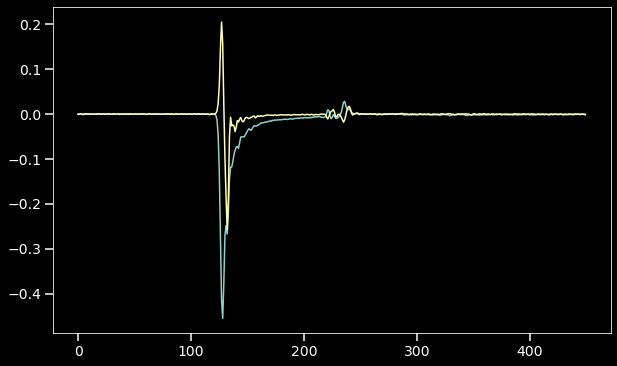

In [7]:
print(acq.svdFit.regressor.A.shape)
fig, ax = plt.subplots()
ax.plot(acq.svdFit.regressor.A[0,:])
ax.plot(0.5*acq.svdFit.regressor.A[1,:])
plt.show()

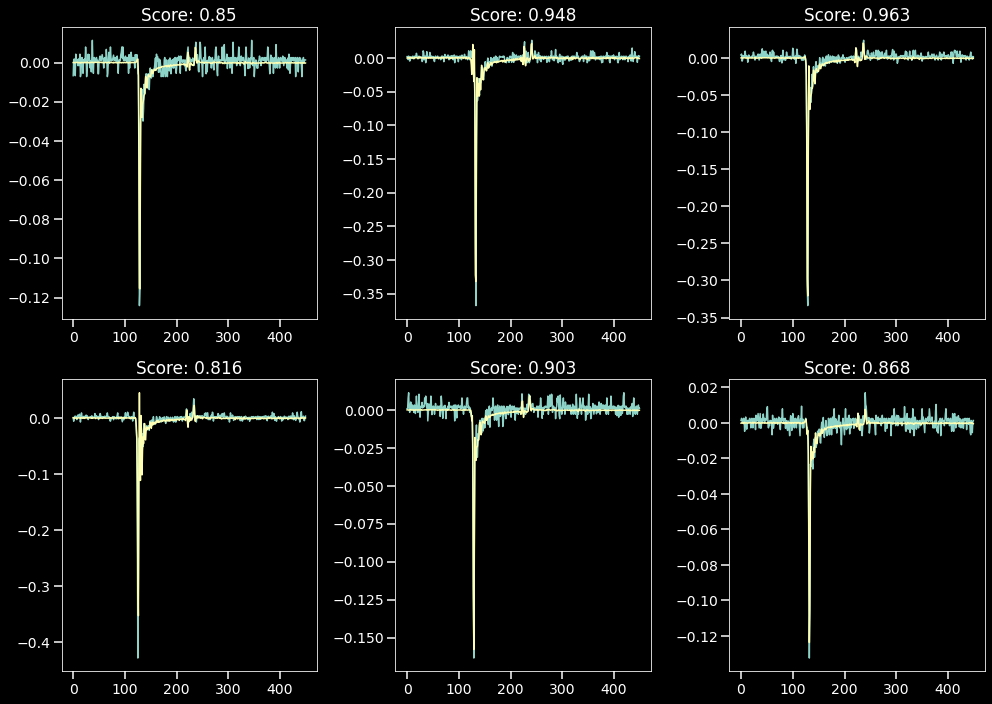

In [8]:
nevt_max = 5
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,10))
axs = axs.ravel()
for nevt,evt in enumerate(ds.events()):
    if nevt>nevt_max:
        break
    acq.getData(evt)
    acq.processFuncs()
    dat = getUserData(acq)
    axs[nevt].set_title('Score: {:.3}'.format(dat['svdFit_score'][0]))
    axs[nevt].plot(acq.evt.dat[0][acq.svdFit.roi[0]:acq.svdFit.roi[1]])
    axs[nevt].plot(dat['svdFit_reconstructed'].T)
plt.tight_layout()
plt.show()

In [9]:
acq.evt.dat.shape

(1, 4000)

## (ii) On multi pulse

In [10]:
expname ='xcsx35017'
run = 70
ds = ps.MPIDataSource('exp=%s:run=%d'%(expname, int(run)))
dsenv = ds.env()

In [12]:
acq = dobj.DetObject('acq01', dsenv, int(run)) # best way to do it
fbasis = './wave_basis_acq01_20200810_121230.h5'
data_basis = h5.File(fbasis,'r')
print(data_basis.keys())

Getting the detector for:  acq01
<KeysViewHDF5 ['A', 'background_index', 'components', 'projector', 'ref_waveforms', 'roi', 'singular_values']>


In [13]:
kwargs = {
    'n_pulse': 4,
    'delay': [-1, 16, 50, 67],
    'return_reconstructed': True
#     'basis_file': fbasis
}
acq.addFunc(svdFit(**kwargs))
acq.svdFit.__dict__

svdFit: basis file found at ./wave_basis_acq01_20200810_121230.h5


/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11-py3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


{'_name': 'svdFit',
 '_debug': False,
 'n_pulse': 4,
 'delay': [-1, 16, 50, 67],
 'return_reconstructed': True,
 'sampling': 1,
 'basis_file': './wave_basis_acq01_20200810_121230.h5',
 '_mode': 'max',
 '_return_reconstructed': True,
 'roi': array([1350, 1800]),
 'bkg_idx': 50,
 'regressor': WaveformRegressor(A=array([[ 2.30161036e-04,  7.02421016e-05, -3.57966677e-04, ...,
         -8.74842085e-04, -1.78785429e-03, -9.16092809e-05],
        [-7.38752667e-04,  1.78890527e-03,  1.34113489e-03, ...,
         -8.12386189e-04, -8.35825137e-04, -9.62219574e-04],
        [-4.22762045e-04, -5.68524814e-04,  4.51870180e-04, ...,
         -6.88310469e-04, -9.67951813e-04, -5.95613020e-05],
        ...,
        [-4.03897632e-04, -...
         -1.57385370e-03,  1.22367143e-03, -7.95873510e-04],
        ...,
        [-6.71296479e-04, -7.01100613e-04, -6.08692833e-04, ...,
         -3.49507385e-04,  5.00527909e-05,  1.38964628e-03],
        [-1.66763781e-03, -8.13287421e-04, -1.02803544e-03, ...,
  

(20, 450)


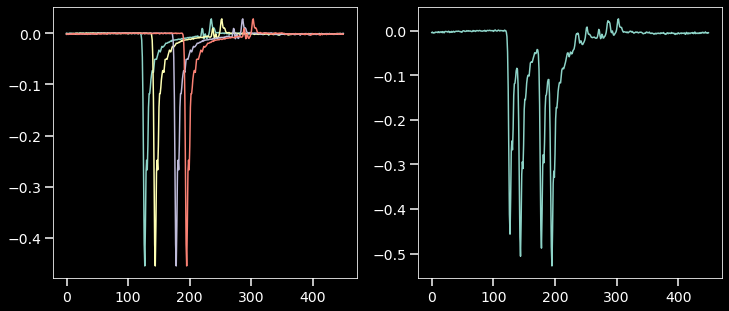

In [14]:
print(acq.svdFit.regressor.A.shape)
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
ax[0].plot(acq.svdFit.regressor.A[0,:])
ax[0].plot(acq.svdFit.regressor.A[5,:])
ax[0].plot(acq.svdFit.regressor.A[10,:])
ax[0].plot(acq.svdFit.regressor.A[15,:])
ax[1].plot(np.sum(acq.svdFit.regressor.A[::5,:], axis=0))
plt.show()

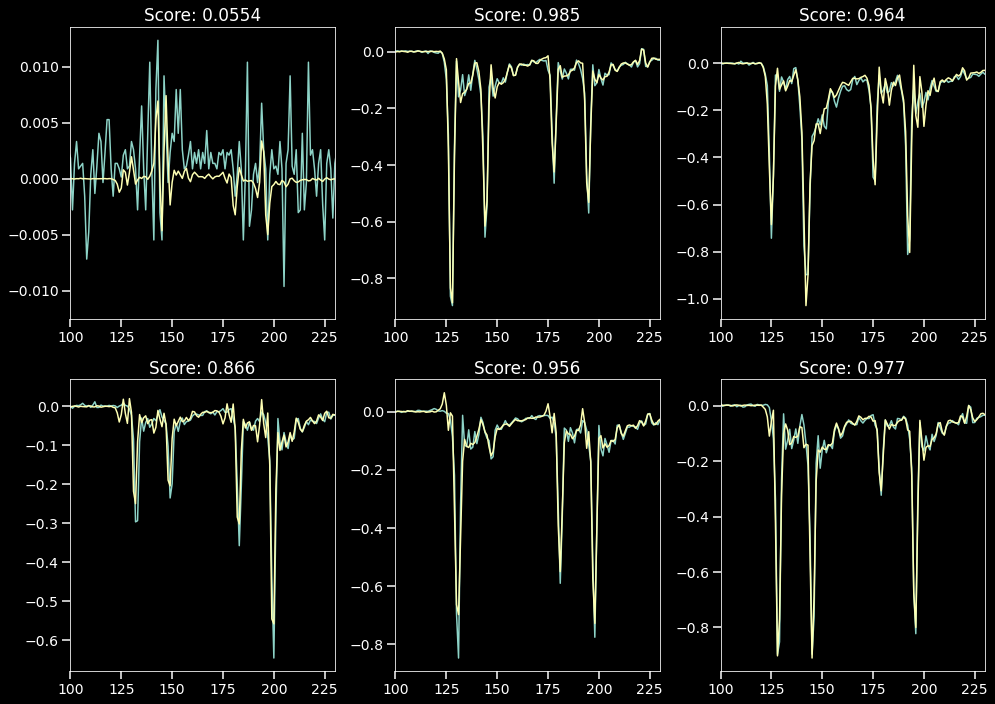

In [15]:
nevt_max = 5
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,10))
axs = axs.ravel()
for nevt,evt in enumerate(ds.events()):
    if nevt>nevt_max:
        break
    acq.getData(evt)
    acq.processFuncs()
    dat = getUserData(acq)
    axs[nevt].set_title('Score: {:.3}'.format(dat['svdFit_score'][0]))
    axs[nevt].plot(acq.evt.dat[0][acq.svdFit.roi[0]:acq.svdFit.roi[1]])
    axs[nevt].plot(dat['svdFit_reconstructed'].T)
    axs[nevt].set_xlim(100,230)
plt.tight_layout()
plt.show()

In [16]:
dat

{'svdFit_intensities': array([[0.05351112, 0.05116553, 0.01654301, 0.04581175]]),
 'svdFit_score': array([0.97706886]),
 'svdFit_coefficients': array([[ 1.03237002,  0.19395776, -0.74851276,  0.40551178,  0.20650672,
          1.02201194,  0.13059615, -0.6808434 ,  0.25092261,  0.23509961,
          0.34161678, -0.01416364, -0.2059795 , -0.00952456,  0.08574558,
          0.96088786, -0.10590582, -0.5570995 , -0.11916602,  0.23773649]]),
 'svdFit_reconstructed': array([[-2.20462454e-03, -1.68266844e-03, -2.82564061e-03,
         -4.57608505e-03, -3.32416306e-03, -3.09512489e-03,
         -2.72701907e-03, -1.79739743e-03, -2.29488597e-03,
         -1.51936739e-03, -2.28419807e-03,  4.08211701e-04,
         -4.07828455e-03, -5.08206873e-03, -1.82309099e-03,
         -3.25975074e-04,  6.20084348e-05, -1.44768524e-03,
         -1.02347649e-03, -1.37527852e-03, -1.79190940e-03,
         -1.94933338e-03, -1.94908858e-03, -6.09249670e-06,
         -1.09901451e-03, -9.20426687e-04, -3.63541621

In [17]:
acq.__dict__

{'det': <Detector.WFDetector.WFDetector at 0x7f9f1dd258d0>,
 '_src': Source("DetInfo(XcsBeamline.0:Acqiris.0)"),
 '_name': 'acq01',
 'run': 70,
 '_storeSum': {},
 'applyMask': 0,
 'dataAccessTime': 0.0,
 'common_mode': -1,
 'rms': None,
 'mask': None,
 'wfx': array([[-7.65101829e-11,  4.84898171e-11,  1.73489817e-10, ...,
          4.99548490e-07,  0.00000000e+00,  0.00000000e+00]]),
 'gain': None,
 'interval': [1.25e-10],
 'delayTime': [0.0],
 'nSamples': [4000],
 'fullScale': [1.0,
  1.35e-321,
  0.0,
  0.0,
  1.40226107e-316,
  1.3911616e-316,
  1.40225316e-316,
  0.0,
  1.11608955e-316,
  1.40224447e-316,
  1.7049734364420206e+16,
  7.583118584468692e+78,
  1.934952648370484e-110,
  1.5148369e-316,
  1.39115763e-316,
  1.4996986760346353e+21,
  1.40221364e-316,
  0.0,
  0.0,
  4e-322],
 'offset': [0.4,
  3.1829936865e-313,
  0.0,
  1.4022571e-316,
  1.3911537e-316,
  1.4022405e-316,
  1.40225316e-316,
  0.0,
  1.11608955e-316,
  1.39116554e-316,
  5.428894738853441e-96,
  1.0859667